In [17]:
#Import all necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from io import StringIO
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import sweetviz as sv
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.window import Window
from pyspark.sql.functions import monotonically_increasing_id
import databricks.koalas as ks 
import pylab as pl

In [20]:
# sc.stop()

In [21]:
#Initialize spark session
conf = pyspark.SparkConf().setAppName('final_project').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

In [22]:
#Read dataset
data = spark.read.format("csv").options(header = 'True', inferSchema='True').csv("green_tripdata_2015-09.csv")

#Add unique ID column
data = data.select(data.columns).withColumn("id", F.monotonically_increasing_id())

# Task 1.
Report how many rows and columns the data file have?

In [23]:
print('Number of rows:', data.count())
print('Number of columns:', len(data.columns))

Number of rows: 1494926
Number of columns: 22


# Task 2.
Collect all the trip distances for all trips. Plot a histogram of the trip distances. You can play with
the number of bins or use the default.

In [24]:
#Get values of the trip distances as a list
trips = data.select('Trip_distance').rdd.flatMap(lambda x:x).collect()
trips[:5]

[0.0, 0.0, 0.59, 0.74, 0.61]

max: 603.1 
min: 0.0


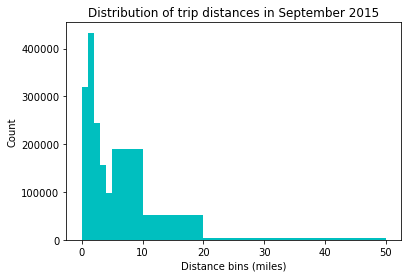

In [26]:
#Plot histogram with different bin sizes
print('max:', max(trips), '\nmin:', min(trips)) #To see if there are outliers
plt.hist(trips, [0,1,2,3,4,5,10,20,50], color = 'c')
plt.title('Distribution of trip distances in September 2015')
plt.xlabel('Distance bins (miles)')
plt.ylabel('Count')
plt.show()

# Data Cleaning
First we will clean the data from null values and outliers. Particularly we will remove trips that took more than 50 miles and have pickup or dropoff locations outside of the city of New York and it's county. We will also remove any trips with zero values for coordinates and distances. By doing these procedures we increase the accuracy of our answers for the tasks below

In [27]:
#Drop null values of coordinates
df = data.dropna(subset = ['Trip_distance', 'Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude', \
                        'Dropoff_latitude'])

#Remove trips that are more than 50 miles
df = df.filter(df.Trip_distance <= 50)

#Remove trips with coordinates too far from New-York
df = df.filter((df.Pickup_longitude > -74.5) & (df.Pickup_longitude < -73))
df = df.filter((df.Pickup_latitude > 39.5) & (df.Pickup_latitude < 41.5))
df = df.filter((df.Dropoff_longitude > -74.5) & (df.Dropoff_longitude < -73))
df = df.filter((df.Dropoff_latitude > 39.5) & (df.Dropoff_latitude < 41.5))

#Create pandas dataframe, sometimes used later for efficiency reasons
df_cleaned_pandas = df.to_pandas_on_spark().to_pandas()

#To see how many rows were removed
print("Number of rows after cleaning:", df.count())

22/04/25 21:45:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/25 21:45:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/25 21:45:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Number of rows after cleaning: 1491288


# Task 3.
Report mean trip distance grouped by pick-up hour of day. (you can do more than we ask – be creative)

+----+------------------+-----+
|Hour|Mean Trip Distance|Count|
+----+------------------+-----+
|   0|3.1161824097428314|67003|
|   1| 3.017130211148168|53659|
|   2|  3.04610198768945|41103|
|   3|3.1934358860619168|31561|
|   4|3.5332493358633896|26350|
|   5|  4.14080954384278|16639|
|   6| 4.057979646017679|22600|
|   7| 3.288080385928902|41873|
|   8| 3.050324336275661|58797|
|   9|2.9995743752223123|61862|
|  10|2.9432867364746724|57300|
|  11|2.9122405539559457|56611|
|  12| 2.904333691843313|57646|
|  13|2.8776262696778687|57298|
|  14| 2.868059124417023|66470|
|  15| 2.858346561565596|73580|
|  16|2.7802843607898637|78949|
|  17|2.6770384497147703|87829|
|  18| 2.653413116274278|97055|
|  19| 2.714806910780874|95966|
|  20| 2.777145789647971|90610|
|  21|   2.9961022149664|86367|
|  22|3.1832037146575267|84530|
|  23|3.1952664824814874|79630|
+----+------------------+-----+



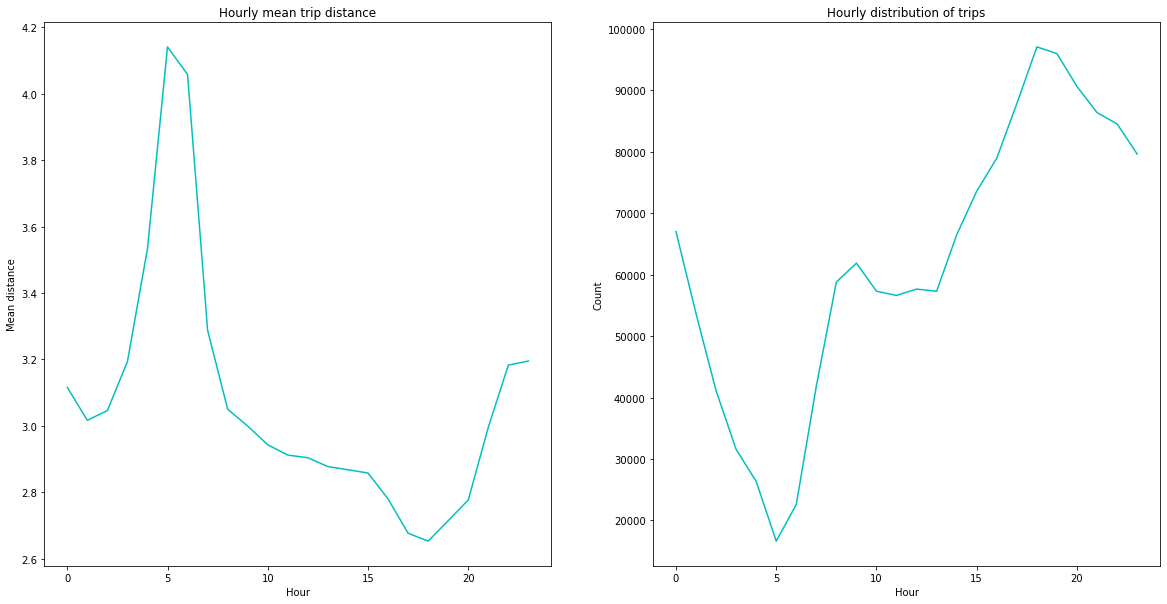

In [28]:
#Getting hour information from the datetime column
temp_df = df.withColumn("hour", F.hour(F.col("lpep_pickup_datetime")))

#Transform to rdd, to make new columns
result = temp_df.select(['hour','Trip_distance']).rdd \
    .groupByKey() \
    .mapValues(lambda x: (sum(list(x))/len(list(x)), len(x))) \
    .sortByKey() \
    .flatMap(lambda x: [(x[0], x[1][0], x[1][1])]) \
    .toDF(['Hour','Mean Trip Distance', 'Count'])
result.show(24)

#Plot mean trip distance
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
x1 = result.select('Hour').rdd.collect()
y1 = result.select('Mean Trip Distance').rdd.collect()
ax[0].plot(x1, y1, color = 'c')
ax[0].set_title('Hourly mean trip distance')
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Mean distance')

#Plot distribution of trips
x2 = result.select('Hour').rdd.collect()
y2 = result.select('Count').rdd.collect()
ax[1].plot(x2, y2, color = 'c')
ax[1].set_title('Hourly distribution of trips')
ax[1].set_xlabel('Hour')
ax[1].set_ylabel('Count')

plt.show()
temp_df.unpersist(); #delete temporary dataframe

+-------+------------------+------+
|weekday|Mean Trip Distance| Count|
+-------+------------------+------+
|      1|3.1787181036401844|220127|
|      2| 2.996514890624276|164936|
|      3|2.8419127147208822|209749|
|      4| 2.866462555910805|224241|
|      5|2.8398240545943945|191082|
|      6| 2.910882908042617|222005|
|      7|  3.10504020868383|259148|
+-------+------------------+------+



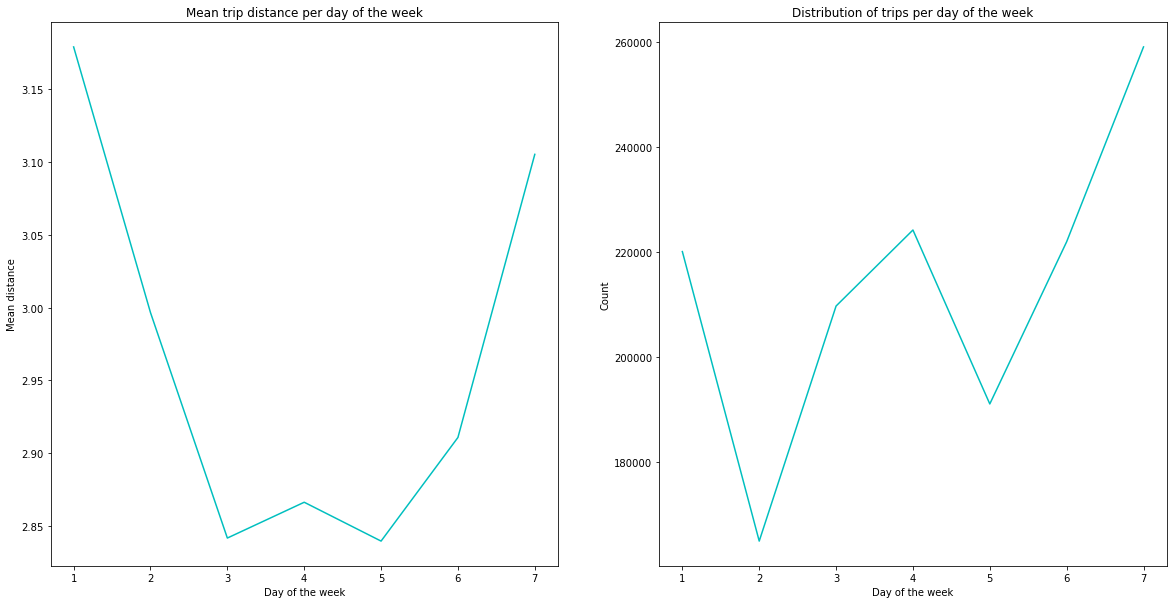

In [29]:
#Extract weekday from the datetime column
temp_df = df.withColumn("weekday", F.dayofweek(F.col("lpep_pickup_datetime")))
result = temp_df.select(['weekday','Trip_distance']).rdd \
    .groupByKey() \
    .mapValues(lambda x: (sum(list(x))/len(list(x)), len(x))) \
    .sortByKey() \
    .flatMap(lambda x: [(x[0], x[1][0], x[1][1])]) \
    .toDF(['weekday','Mean Trip Distance', 'Count'])
result.show(7)

#Plot mean trip distance
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
x1 = result.select('weekday').rdd.collect()
y1 = result.select('Mean Trip Distance').rdd.collect()
ax[0].plot(x1, y1, color = 'c')
ax[0].set_title('Mean trip distance per day of the week')
ax[0].set_xlabel('Day of the week')
ax[0].set_ylabel('Mean distance')

#Plot distribution of trips
x2 = result.select('weekday').rdd.collect()
y2 = result.select('Count').rdd.collect()
ax[1].plot(x2, y2, color = 'c')
ax[1].set_title('Distribution of trips per day of the week')
ax[1].set_xlabel('Day of the week')
ax[1].set_ylabel('Count')

plt.show()
temp_df.unpersist(); #Delete temporary dataframe

+----------+------------------+-----+
|       Day|Mean Trip Distance|Count|
+----------+------------------+-----+
|2015-09-01| 2.874646630324662|41458|
|2015-09-02|2.9507033180170317|43309|
|2015-09-03|2.9049627971563927|48249|
|2015-09-04|3.0148284486272185|53978|
|2015-09-05| 3.170288230584427|58703|
|2015-09-06|3.1788052295966267|53006|
|2015-09-07| 3.195317288216367|41965|
|2015-09-08| 2.904299867129758|42899|
|2015-09-09|  2.88106657521328|46654|
|2015-09-10|2.7260709763978785|52919|
|2015-09-11|  2.92167485421453|56590|
|2015-09-12|3.0718545900805485|66818|
|2015-09-13| 3.172062589161575|55377|
|2015-09-14| 2.968359468931467|39091|
|2015-09-15|2.8577140700703514|41073|
|2015-09-16|2.8713789928919966|46708|
|2015-09-17| 2.854053208137702|49842|
|2015-09-18|2.8944815331010494|57400|
|2015-09-19|3.1246599293016506|68177|
|2015-09-20| 3.195409951068928|57019|
|2015-09-21| 2.939465904237671|42146|
|2015-09-22|2.7888426164373703|40773|
|2015-09-23| 2.873193328463588|41070|
|2015-09-24|

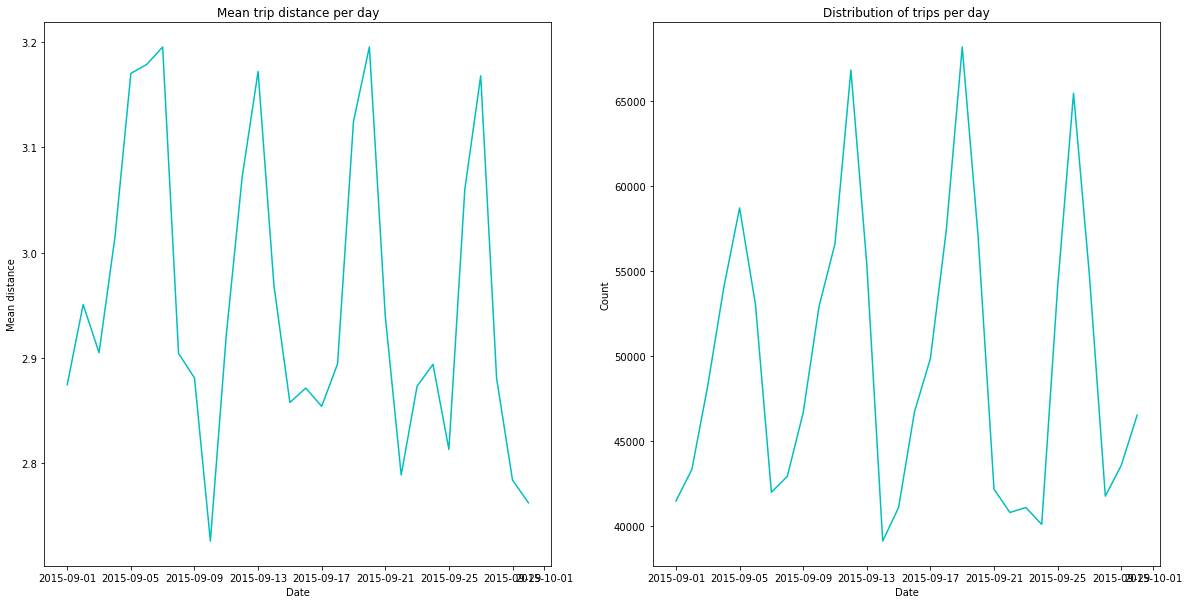

In [30]:
#Extract exact date from the datetime column
temp_df = df.withColumn("day", F.to_date(F.col("lpep_pickup_datetime")))
result = temp_df.select(['day','Trip_distance']).rdd \
    .groupByKey() \
    .mapValues(lambda x: (sum(list(x))/len(list(x)), len(x))) \
    .sortByKey() \
    .flatMap(lambda x: [(x[0], x[1][0], x[1][1])]) \
    .toDF(['Day','Mean Trip Distance', 'Count'])
result.show(30)

#Plot mean trip distance
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
x1 = result.select('Day').rdd.collect()
y1 = result.select('Mean Trip Distance').rdd.collect()
ax[0].plot(x1, y1, color = 'c')
ax[0].set_title('Mean trip distance per day')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Mean distance')

#Plot the distribution of the trips
x2 = result.select('Day').rdd.collect()
y2 = result.select('Count').rdd.collect()
ax[1].plot(x2, y2, color = 'c')
ax[1].set_title('Distribution of trips per day')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Count')

plt.show()
temp_df.unpersist(); #delete temporary dataframe

# Task 4.
We’d like to get a rough sense of identifying trips that terminate at one of the NYC area airports.
Can you provide a count of how many transactions fit this criteria, the average fair, and any other
interesting characteristics of these trips.

## Dropoffs

In [38]:
#Function that helps to visualize the coordinates on the NYC map
def scatterOnMap(df, columns, title):
    nycmap = gpd.read_file('nyc.shx') #load NYC map shapefile using geopandas
    fig, ax = plt.subplots(figsize = (10, 10))
    nycmap.plot(ax = ax, color = 'grey', alpha = 0.2) #plot the map
    
    crs = {'init': 'epsg:4326'} #coordinate standard system
    longitude = df.select(columns[0]).rdd.flatMap(lambda x:x).collect()
    latitude = df.select(columns[1]).rdd.flatMap(lambda x:x).collect()
    geometry = gpd.points_from_xy(longitude, latitude) #transform coordinates to readable by geopandas dtype
    
    geo_df = gpd.GeoDataFrame(df.toPandas(), crs = crs, geometry = geometry) #add transformed coordinates to the dataframe
    geo_df.plot(ax = ax, markersize = 15, color = 'm', marker = 'x') #plot the coordinates on the map
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(title)
    plt.show()

In [39]:
#JFK airport coordinates and desired radius
jfk_lat = 40.652925
jfk_long = -73.791687
jfk_rad = 0.010
#select trips that finished around JFK
jfk = df.select(df.columns).where(F.abs(jfk_long - df.Dropoff_longitude) <= jfk_rad)
jfk = jfk.select(jfk.columns).where(F.abs(jfk_lat - jfk.Dropoff_latitude) <= jfk_rad)
jfk = jfk.dropna(subset = ['Dropoff_longitude', 'Dropoff_latitude'])
print('Amount of dropoffs near JFK Airport:', jfk.count())

#Laguardia airport coordinates and desired radius
lag_lat = 40.776599
lag_long = -73.873771
lag_rad = 0.005
#select trips that finished around LaGuardia
lag = df.select(df.columns).where(F.abs(lag_long - df.Dropoff_longitude) <= lag_rad)
lag = lag.select(lag.columns).where(F.abs(lag_lat - lag.Dropoff_latitude) <= lag_rad)
lag = lag.dropna(subset = ['Dropoff_longitude', 'Dropoff_latitude'])
print('Amount of dropoffs near LaGuardia Airport:', lag.count())

#Newark airport coordinates and desired radius
ewr_lat = 40.690488
ewr_long = -74.174890
ewr_rad = 0.020
#select trips that finished around Newark
ewr = df.select(df.columns).where(F.abs(ewr_long - df.Dropoff_longitude) <= ewr_rad)
ewr = ewr.select(ewr.columns).where(F.abs(ewr_lat - ewr.Dropoff_latitude) <= ewr_rad)
ewr = ewr.dropna(subset = ['Dropoff_longitude', 'Dropoff_latitude'])
print('Amount of dropoffs near Newark Liberty Airport:', ewr.count())

#Union of all dataframes
total = jfk.union(lag).union(ewr)
print('Total amount of dropffs near any airport in NYC', total.count())

Amount of dropoffs near JFK Airport: 8874


Amount of dropoffs near LaGuardia Airport: 11632


Amount of dropoffs near Newark Liberty Airport: 729


Total amount of dropffs near any airport in NYC 21235


Average fare amount of trips that finish near airport: [Row(avg(Fare_amount)=31.25067012008477)]


/home/maksat.kengeskanov/.conda/envs/GOS/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


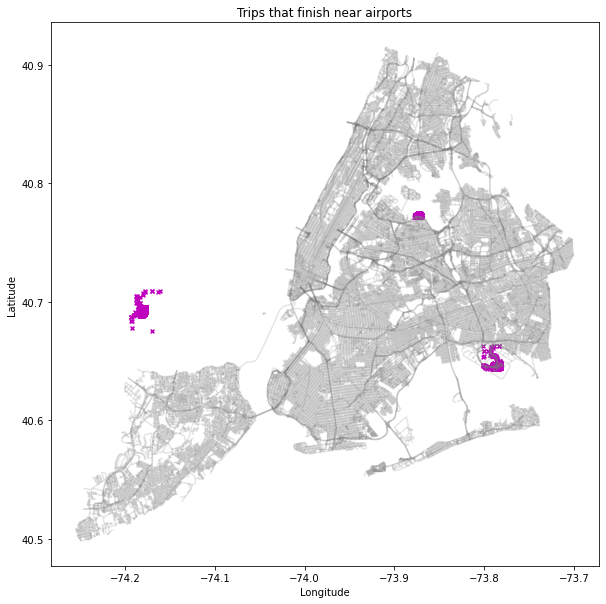

In [40]:
#Compute average fare amount of airport trips
avg_fare = total.select(F.mean('Fare_amount')).collect()
print('Average fare amount of trips that finish near airport:', avg_fare)
#Plot the dropoff locations on the map
title = 'Trips that finish near airports'
scatterOnMap(total, ['Dropoff_longitude', 'Dropoff_latitude'], title)
#Delete all redundant dataframes
jfk.unpersist();
lag.unpersist();
ewr.unpersist();
total.unpersist();

## Pickups

In [41]:
#JFK airport
jfk_lat = 40.652925
jfk_long = -73.791687
jfk_rad = 0.010
#select trips that started around JFK
jfk = df.select(df.columns).where(F.abs(jfk_long - df.Pickup_longitude) <= jfk_rad)
jfk = jfk.select(jfk.columns).where(F.abs(jfk_lat - jfk.Pickup_latitude) <= jfk_rad)
jfk = jfk.dropna(subset = ['Pickup_longitude', 'Pickup_latitude'])
print('Amount of pickups near JFK Airport:', jfk.count())

#Laguardia airport
lag_lat = 40.776599
lag_long = -73.873771
lag_rad = 0.005
#select trips that started around LaGuardia
lag = df.select(df.columns).where(F.abs(lag_long - df.Pickup_longitude) <= lag_rad)
lag = lag.select(lag.columns).where(F.abs(lag_lat - lag.Pickup_latitude) <= lag_rad)
lag = lag.dropna(subset = ['Pickup_longitude', 'Pickup_latitude'])
print('Amount of pickups near LaGuardia Airport:', lag.count())

#Newark airport
ewr_lat = 40.690488
ewr_long = -74.174890
ewr_rad = 0.020
#select trips that started around Newark
ewr = df.select(df.columns).where(F.abs(ewr_long - df.Pickup_longitude) <= ewr_rad)
ewr = ewr.select(ewr.columns).where(F.abs(ewr_lat - ewr.Pickup_latitude) <= ewr_rad)
ewr = ewr.dropna(subset = ['Pickup_longitude', 'Pickup_latitude'])
print('Amount of pickups near Newark Liberty Airport:', ewr.count())

#Union of the dataframes
total = jfk.union(lag).union(ewr)
print('Total amount of dropffs near any airport in NYC', total.count())

Amount of pickups near JFK Airport: 194


Amount of pickups near LaGuardia Airport: 149


Amount of pickups near Newark Liberty Airport: 44


Total amount of dropffs near any airport in NYC 387


Average fare amount of trips that start near airport: [Row(avg(Fare_amount)=35.36462532299742)]


/home/maksat.kengeskanov/.conda/envs/GOS/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


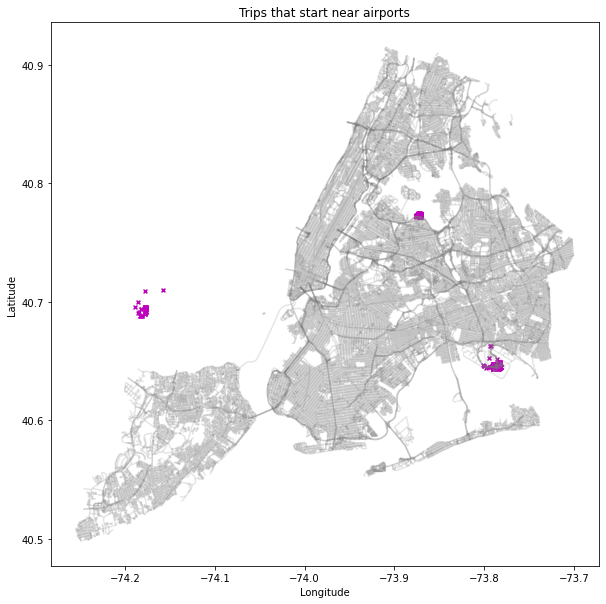

In [42]:
#Compute average fare amount
avg_fare = total.select(F.mean('Fare_amount')).collect()
print('Average fare amount of trips that start near airport:', avg_fare)
#Draw pickup coordinates on the map
title = "Trips that start near airports"
scatterOnMap(total, ['Pickup_longitude', 'Pickup_latitude'], title)
#Delete redundant dataframes
jfk.unpersist();
lag.unpersist();
ewr.unpersist();
total.unpersist();

# Task 5.
Do two clusterings on pick-up and drop-off locations respectively. Choose a proper number of clusters
k and report the centroids. Is there much difference between centroids for pick-up and drop-off? Note:
do not set the maximal k too large in your code. k from 2 to 10 - 20 should be enough to try.

## Clustering pickups

In [43]:
#Prepare features for clustering and do some data cleaning
features = VectorAssembler(inputCols = ['Pickup_longitude', 'Pickup_latitude'], outputCol = "features")
pu = df.filter((df['Pickup_longitude'] != 0.0) & (df['Pickup_latitude'] != 0.0))
pu = pu.dropna(subset = ['Pickup_longitude', 'Pickup_latitude'])
pu = features.transform(pu)

### Finding appropriate values of K
### Warning: This cell takes approx. 20 minutes to run

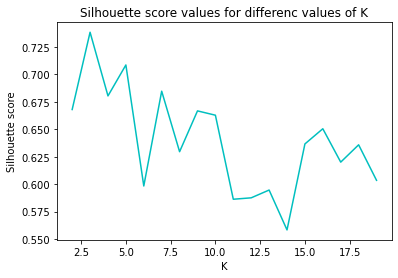

In [45]:
#This cell takes about 20 mins to run
#We recommend not to run it
silhouette = []
metric = ClusteringEvaluator() #Silhouette score by default

#Run K means clustering for K from 2 to 20
for k in range(2, 20):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(pu)
    prediction = model.transform(pu)
    
    score = metric.evaluate(prediction)
    silhouette.append(score)

#plot silhouette scores of different K values
plt.plot(range(2,20), silhouette, color = 'c')
plt.title('Silhouette score values for different values of K')
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.show()

We select one of the local maximums that is not very small. We found it to be 10 as for the dropoff this values is also valid

In [46]:
#Do clustering with K = 10
kmeans = KMeans().setK(10).setSeed(1)
model1 = kmeans.fit(pu)
pu_pred = model1.transform(pu)

#Get centroid coordinates
centers = model1.clusterCenters()
pickups = spark.createDataFrame([i.tolist() for i in centers], ['longitude', 'latitude'])
pickups.show()
pu.unpersist(); #Delete redundant dataframes

+------------------+------------------+
|         longitude|          latitude|
+------------------+------------------+
|-73.91197684714443|40.756356150750676|
|-73.94471944398566|40.680141904624186|
|-73.94884663726002| 40.80273644292848|
|-73.81605495858348|  40.7037609629537|
|-73.86117193678812| 40.74151735830128|
|-73.87850674143338|40.854220427502945|
|-73.93359199312424| 40.83393236607849|
|-73.96516752073107| 40.61225908592293|
|-73.95491945094453| 40.72125332375085|
|-73.98531355530781|40.686016859474115|
+------------------+------------------+



## Dropoffs

In [47]:
#Prepare features for clustering and do some data cleaning 
features = VectorAssembler(inputCols = ['Dropoff_longitude', 'Dropoff_latitude'], outputCol = "features")
do = df.filter((df['Dropoff_longitude'] != 0.0) & (df['Dropoff_latitude'] != 0.0))
do = do.dropna(subset = ['Dropoff_longitude', 'Dropoff_latitude'])
do = features.transform(do)

### Finding appropriate values of K
### Warning: This cell takes approx. 20 minutes to run

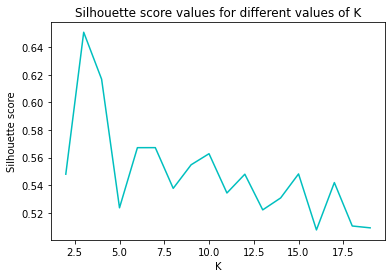

In [49]:
#This cell takes about 20 mins to run
#We recommend not to run it
silhouette = []
metric = ClusteringEvaluator() #Silhouette score by default

#Run K means clustering for K from 2 to 20
for k in range(2, 20):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(do)
    prediction = model.transform(do)
    
    score = metric.evaluate(prediction)
    silhouette.append(score)

#plot silhouette scores of different K values
plt.plot(range(2,20), silhouette, color = 'c')
plt.title('Silhouette score values for different values of K')
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.show()

We can see that here K = 10 is close to local maxima. Since for pickups we had 10 clusters it's better to choose the same number for dropoff in order to be able to compare

In [50]:
#Do clustering with K = 10
kmeans = KMeans().setK(10).setSeed(1)
model = kmeans.fit(do)
do_pred = model.transform(do)

#Get centroid coordinates
centers = model.clusterCenters()
dropoffs = spark.createDataFrame([i.tolist() for i in centers], ['longitude', 'latitude'])
dropoffs.show()
do.unpersist(); #Delete redundant dataframes

+------------------+------------------+
|         longitude|          latitude|
+------------------+------------------+
|-73.97486635404523| 40.75411781886004|
|-73.89797839848688| 40.85133817749795|
|-73.81846633187779| 40.69523214156104|
| -73.9477341851585|40.647436440936495|
|-73.75843167473084| 40.73331314774028|
|-73.94713661949824|40.805330562008976|
|-73.88804035856445|40.753145030127065|
|-74.17116314547879|40.675743523177566|
| -73.9885589197571| 40.68651400421045|
|-73.94332925047976|40.702401550595084|
+------------------+------------------+



## Plot all coordinates on the map

/home/maksat.kengeskanov/.conda/envs/GOS/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/maksat.kengeskanov/.conda/envs/GOS/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/maksat.kengeskanov/.conda/envs/GOS/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>

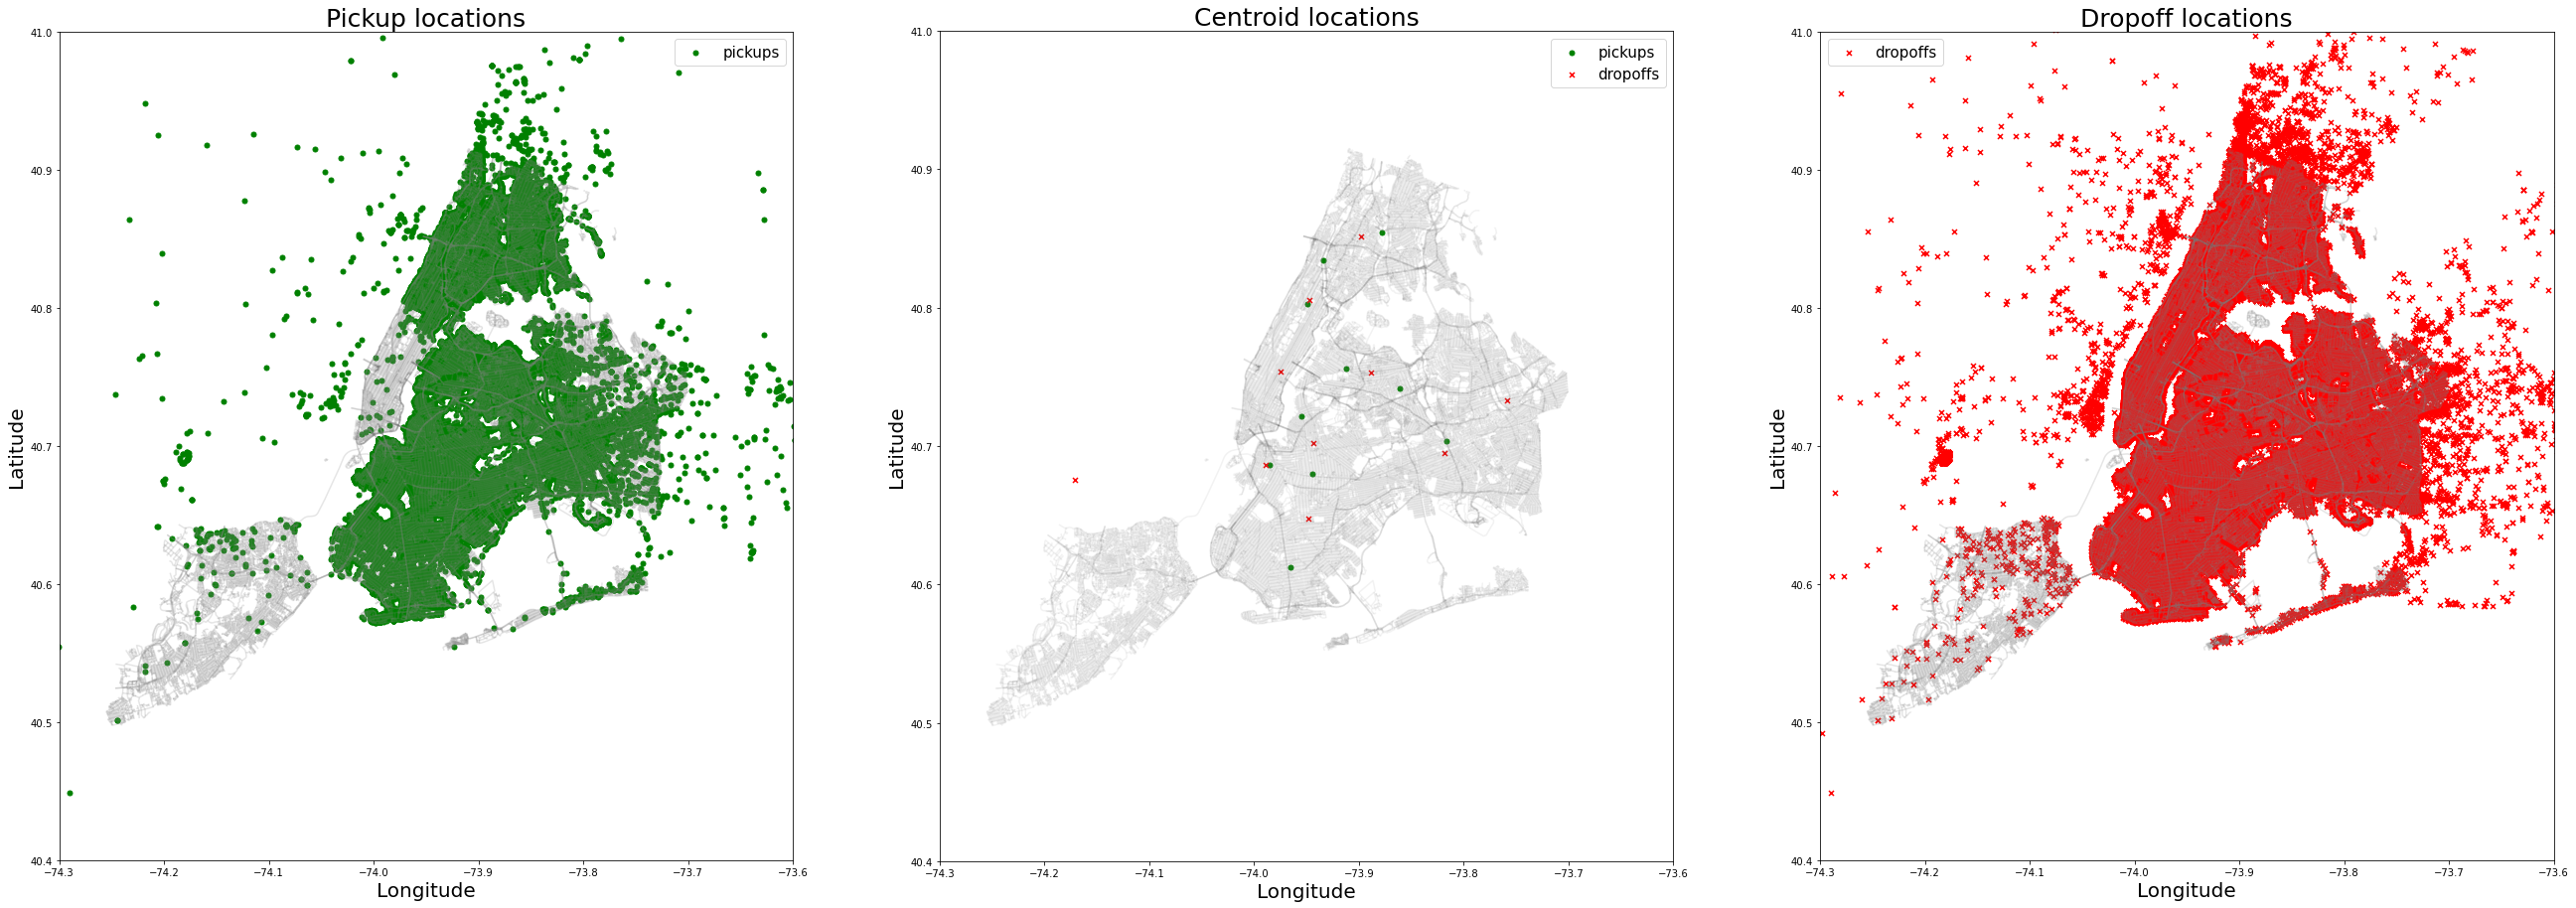

In [56]:
#Plot NYC map on the coordinate system
nycmap = gpd.read_file('nyc.shx')
fig, ax = plt.subplots(1, 3, figsize = (45, 45))
crs = {'init': 'epsg:4326'}
nycmap.plot(ax = ax[0], color = 'grey', alpha = 0.2)
nycmap.plot(ax = ax[1], color = 'grey', alpha = 0.1)
nycmap.plot(ax = ax[2], color = 'grey', alpha = 0.2)

#Plot ALL pickup locations 
pu_all_long = df.select('Pickup_longitude').rdd.flatMap(lambda x:x).collect()
pu_all_lat = df.select('Pickup_latitude').rdd.flatMap(lambda x:x).collect()
geometry = gpd.points_from_xy(pu_all_long, pu_all_lat)
geo_pu_all = gpd.GeoDataFrame(df.toPandas(), crs = crs, geometry = geometry)
geo_pu_all.plot(ax = ax[0], markersize = 25, color = 'g', marker = 'o', label = 'pickups') 

#Plot ALL dropoff locations
do_all_long = df.select('Dropoff_longitude').rdd.flatMap(lambda x:x).collect()
do_all_lat = df.select('Dropoff_latitude').rdd.flatMap(lambda x:x).collect()
geometry = gpd.points_from_xy(do_all_long, do_all_lat)
geo_do_all = gpd.GeoDataFrame(df.toPandas(), crs = crs, geometry = geometry)
geo_do_all.plot(ax = ax[2], markersize = 25, color = 'r', marker = 'x', label = 'dropoffs')

#Plot centroids of the pickups
pu_long = pickups.select('longitude').rdd.flatMap(lambda x:x).collect()
pu_lat = pickups.select('latitude').rdd.flatMap(lambda x:x).collect()
geometry = gpd.points_from_xy(pu_long, pu_lat)
geo_pu = gpd.GeoDataFrame(pickups.toPandas(), crs = crs, geometry = geometry)
geo_pu.plot(ax = ax[1], markersize = 25, color = 'g', marker = 'o', label = 'pickups')

#Plot centroids of the dropoffs
do_long = dropoffs.select('longitude').rdd.flatMap(lambda x:x).collect()
do_lat = dropoffs.select('latitude').rdd.flatMap(lambda x:x).collect()
geometry = gpd.points_from_xy(do_long, do_lat)
geo_do = gpd.GeoDataFrame(dropoffs.toPandas(), crs = crs, geometry = geometry)
geo_do.plot(ax = ax[1], markersize = 25, color = 'r', marker = 'x', label = 'dropoffs')

#Limit axes to view the map better, note that some coordinates were left outside
ax[0].legend(prop={'size': 15})
ax[0].set_xlim([-74.3, -73.6])
ax[0].set_ylim([40.4, 41])
ax[0].set_xlabel('Longitude', fontsize = 20)
ax[0].set_ylabel('Latitude', fontsize = 20)
ax[0].set_title('Pickup locations', fontsize = 25)
ax[1].legend(prop={'size': 15})
ax[1].set_xlim([-74.3, -73.6])
ax[1].set_ylim([40.4, 41])
ax[1].set_xlabel('Longitude', fontsize = 20)
ax[1].set_ylabel('Latitude', fontsize = 20)
ax[1].set_title('Centroid locations', fontsize = 25)
ax[2].legend(prop={'size': 15})
ax[2].set_xlim([-74.3, -73.6])
ax[2].set_ylim([40.4, 41])
ax[2].set_xlabel('Longitude', fontsize = 20)
ax[2].set_ylabel('Latitude', fontsize = 20)
ax[2].set_title('Dropoff locations', fontsize = 25)
plt.show()

# Task 6.
Cluster pick-up and drop-off locations. Choose a proper number of clusters k and report the centroids
(you can use google maps to show centroids). What is the percentage of trips for each cluster? What
is percentage of trips where pick-up and drop-off are in the same cluster? What have you learnt from
this?

We can't answer both question above using only clustering, please refer to project report for the details. We will do two separate clusterings.

## What is the percentage of trips for each cluster?
#### We cluster based on 4 features which are the coordinates of both pickup and dropoff. In this way we are clustering the trips instead of the locations. And determine the distribution of each cluster

In [57]:
#Prepare dataframes for clustering by transforming features
features = VectorAssembler(inputCols = ['Pickup_longitude', 'Pickup_latitude', \
                                        'Dropoff_longitude', 'Dropoff_latitude'], outputCol = "features")
all_trips = df.filter((df['Dropoff_longitude'] != 0.0) & (df['Dropoff_latitude'] != 0.0) & \
                      (df['Pickup_longitude'] != 0.0) & (df['Pickup_latitude'] != 0.0))
all_trips = all_trips.dropna(subset = ['Pickup_longitude', 'Pickup_latitude', \
                                        'Dropoff_longitude', 'Dropoff_latitude'])
all_trips = features.transform(all_trips)

### Finding appropriate value of K. Warning, this may take up to 30 minutes to run

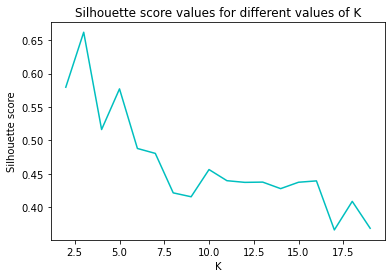

In [58]:
#This cell takes about 30 mins to run
#We recommend not to run it
silhouette = []
metric = ClusteringEvaluator()

#Run K means clustering for K in range (2, 20)
for k in range(2, 20):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(all_trips)
    prediction = model.transform(all_trips)
    
    score = metric.evaluate(prediction)
    silhouette.append(score)

#Plot the silhouette score
plt.plot(range(2, 20), silhouette, color = 'c')
plt.xlabel('K')
plt.title('Silhouette score values for different values of K')
plt.ylabel('Silhouette score')
plt.show()

In [62]:
#Do clustering with K=10, printing centers and cluster sizes
kmeans = KMeans().setK(10).setSeed(1)
model2 = kmeans.fit(all_trips)
trips_pred = model2.transform(all_trips)

#Computing additional information such as avg, min and max
cluster_size = trips_pred.groupBy('prediction').agg({'id': 'count', 'Trip_distance': 'avg', 'Total_amount': 'avg'})
cluster_size_m = trips_pred.groupBy('prediction').agg({'Trip_distance': 'min', 'Total_amount': 'min'})
cluster_size_M = trips_pred.groupBy('prediction').agg({'Trip_distance': 'max', 'Total_amount': 'max'})
cluster_size = cluster_size.join(cluster_size_m, ("prediction")).join(cluster_size_M, ("prediction"))
cluster_size = cluster_size.withColumn('percentage',F.col('count(id)')/F.sum('count(id)').over(Window.partitionBy())*100)
cluster_size = cluster_size.orderBy('prediction').withColumnRenamed('count(id)', 'size')
centers = model2.clusterCenters()
centers = spark.createDataFrame([i.tolist() for i in centers], ['pickup_longitude', 'pickup_latitude', \
                                                               'dropoff_longitude', 'dropoff_latitude'])
centers.show()

cluster_size.show()

+------------------+------------------+------------------+------------------+
|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|
+------------------+------------------+------------------+------------------+
|-73.89966415245529| 40.75173147489932|-73.89956134627522| 40.75355645209109|
|-73.96041927911237| 40.71264741954089| -73.9656202757032| 40.73562212057524|
|-73.83780794032832| 40.72579066379486|-73.82799630974894| 40.72104004376014|
|-73.96439679120039| 40.63780961838653|-73.96026478841775| 40.62607989160251|
|-73.94508446083636|40.810187306431004|-73.94383530104813|  40.8117641780243|
|-73.94134699365853|  40.7360747812661|-73.78631525346897|40.667583582289595|
|-73.90332050843207| 40.84315607125513|-73.89319879131749|  40.8512515686593|
|-73.98078679763083| 40.68644195721355|-73.98516675611818|40.684743046797784|
|-73.95135663052177|40.693450076094905|  -73.936584998213|40.684702033683386|
|-73.94383877375583|40.798886213804444|-73.97284191860872|40.763

22/04/25 23:52:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/25 23:52:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/25 23:52:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/25 23:52:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/25 23:52:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/25 23:52:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/25 2

+----------+------------------+------------------+------+------------------+-----------------+------------------+-----------------+------------------+
|prediction|avg(Trip_distance)| avg(Total_amount)|  size|min(Trip_distance)|min(Total_amount)|max(Trip_distance)|max(Total_amount)|        percentage|
+----------+------------------+------------------+------+------------------+-----------------+------------------+-----------------+------------------+
|         0|2.6159918440226044|13.325704379890576|264346|               0.0|           -120.0|             47.38|            300.3|17.726019387267918|
|         1| 3.928723828847871| 19.32600760330792|179396|               0.0|            -75.0|              45.4|            500.0|12.029601257436525|
|         2|2.9391368174974346|14.228708197960652|100952|               0.0|           -400.0|              49.0|            450.0|  6.76945030067968|
|         3|3.3905943644969696|16.442609993960666| 31479|               0.0|           -450.0|

22/04/25 23:52:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


/home/maksat.kengeskanov/.conda/envs/GOS/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/maksat.kengeskanov/.conda/envs/GOS/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


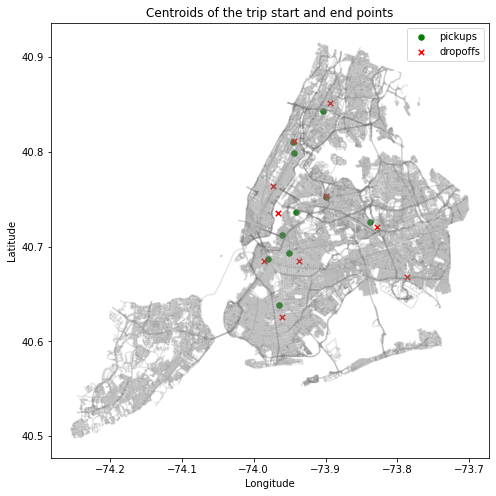

In [63]:
#Plot the centroids of the clusters on the map
nycmap = gpd.read_file('nyc.shx')
fig, ax = plt.subplots(figsize = (8, 8))
crs = {'init': 'epsg:4326'}
nycmap.plot(ax = ax, color = 'grey', alpha = 0.2)

#Plot pickup centroids
pu_all_long = centers.select('pickup_longitude').rdd.flatMap(lambda x:x).collect()
pu_all_lat = centers.select('pickup_latitude').rdd.flatMap(lambda x:x).collect()
geometry = gpd.points_from_xy(pu_all_long, pu_all_lat)
geo_pu_all = gpd.GeoDataFrame(centers.toPandas(), crs = crs, geometry = geometry)
geo_pu_all.plot(ax = ax, markersize = 30, color = 'g', marker = 'o', label = 'pickups') 

#Plot dropoff centroids
do_all_long = centers.select('dropoff_longitude').rdd.flatMap(lambda x:x).collect()
do_all_lat = centers.select('dropoff_latitude').rdd.flatMap(lambda x:x).collect()
geometry = gpd.points_from_xy(do_all_long, do_all_lat)
geo_do_all = gpd.GeoDataFrame(centers.toPandas(), crs = crs, geometry = geometry)
geo_do_all.plot(ax = ax, markersize = 30, color = 'r', marker = 'x', label = 'dropoffs')

ax.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Centroids of the trip start and end points')
plt.show()

### What is percentage of trips where pick-up and drop-off are in the same cluster?
#### To answer this question we concatenate the coordinates of pickups and the dropoff and the cluster them all. After that we check if the same trip started and ended in the same cluster

In [64]:
#Get only pickup coordinates
pickup_xy = df.select(['id', 'Pickup_longitude', 'Pickup_latitude']) \
    .withColumn('type', F.lit(1)) \
    .withColumnRenamed('Pickup_longitude', 'long') \
    .withColumnRenamed('Pickup_latitude', 'lat') #type = 1 for pickups

#Get only dropoff coordinates
dropoff_xy = df.select(['id', 'Dropoff_longitude', 'Dropoff_latitude']) \
    .withColumn('type', F.lit(0)) \
    .withColumnRenamed('Dropoff_longitude', 'long') \
    .withColumnRenamed('Dropoff_latitude', 'lat')#type = 0 for dropoffs

#Concatenate the coordinates
xy = pickup_xy.union(dropoff_xy)
xy.show(5)

+---+------------------+------------------+----+
| id|              long|               lat|type|
+---+------------------+------------------+----+
|  0|-73.97948455810547| 40.68495559692383|   1|
|  1|-74.01079559326172| 40.91221618652344|   1|
|  2| -73.9214096069336| 40.76670837402344|   1|
|  3|   -73.92138671875| 40.76667785644531|   1|
|  4|-73.95548248291016|40.714046478271484|   1|
+---+------------------+------------------+----+
only showing top 5 rows



In [65]:
#Transform features into suitable format
features = VectorAssembler(inputCols = ['long', 'lat'], outputCol = "features")
xy = features.transform(xy)

### Finding K. Warning: this may take 30-40 minutes.

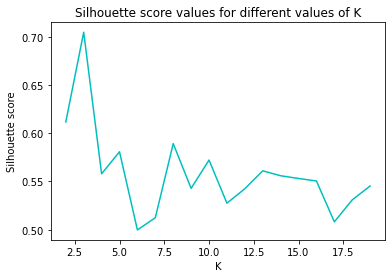

In [66]:
#This cell takes about 30 mins to run
#We recommend not to run it
silhouette = []
metric = ClusteringEvaluator() #Silhouette score by default

#Finding K in range between 2 to 20
for k in range(2, 20):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(xy)
    prediction = model.transform(xy)
    
    score = metric.evaluate(prediction)
    silhouette.append(score)

#Plotting the graph of silhouette score
plt.plot(range(2, 20), silhouette, color = 'c')
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.title('Silhouette score values for different values of K')
plt.show()

Once again we see that there is a local maxima at 10. 

In [67]:
#K=10, printing centers and cluster sizes
kmeans = KMeans().setK(10).setSeed(1)
model2 = kmeans.fit(xy)
results = model2.transform(xy)
results.show(5)

+---+------------------+------------------+----+--------------------+----------+
| id|              long|               lat|type|            features|prediction|
+---+------------------+------------------+----+--------------------+----------+
|  0|-73.97948455810547| 40.68495559692383|   1|[-73.979484558105...|         3|
|  1|-74.01079559326172| 40.91221618652344|   1|[-74.010795593261...|         2|
|  2| -73.9214096069336| 40.76670837402344|   1|[-73.921409606933...|         1|
|  3|   -73.92138671875| 40.76667785644531|   1|[-73.92138671875,...|         1|
|  4|-73.95548248291016|40.714046478271484|   1|[-73.955482482910...|         0|
+---+------------------+------------------+----+--------------------+----------+
only showing top 5 rows



In [68]:
#Compute the percentage of trips in the same cluster
pickups = results.filter(results.type == 1).drop('type').drop('features').withColumnRenamed('prediction', 'pred1')
dropoffs = results.filter(results.type == 0).drop('type').drop('features').withColumnRenamed('prediction', 'pred2')
trips = pickups.join(dropoffs, 'id', how = 'inner')
same_cluster = trips.filter(trips.pred1 == trips.pred2)
answer = same_cluster.count() / trips.count() * 100
print('What percentage of trips end and start in the same cluster:', answer)

What percentage of trips end and start in the same cluster: 55.7422174657075


# Task 7.
Figure 2 is a visualization for a small number of trips. It gives us a rough sense where the trips happen.
Since the Hudson River, which is the boundary of New Jersey and NYC in this area, is quite straight,
we can use a line to model this natural boundary. The approximated line in latitude (y) and longitude
(x) can be represented as: <br>
y = 1.323942 ∗ x + 138.669195 <br>
If a location satisfies y > 1.323942x + 138.669195, it’s in New Jersey. If a location satisfies y <
1.323942x + 138.669195, it’s in Manhattan. After such processing, we can get Figure 2. In this way,
we can better utilize the pick-up and drop-off latitude-longitude data.
2
In this task, you are expected to group all trips into the following four categories, NJ → NJ, NJ
→ NYC, NYC → NJ, NYC → NYC. Can you build some association rules on intra- vs. inter-borough
traffic? What story does it tell about how New Yorkers use their green taxis? For example, in which
hour of the day, there would be more inter-borough traffic than intra-borough traffic? For those NYC
→ NYC trips, people are more likely to take taxis from uptown to downtown or from downtown to
uptown? There are many interesting stories in the data, feel free to discover some. Again, you can
create new features as needed.

In [69]:
a = 1.323942
b = 138.669195

In [70]:
#Find trips that go from NJ to NJ and extract additional information from the date
nj_nj = df.filter((df.Pickup_longitude * a + b <= df.Pickup_latitude) & \
                 (df.Dropoff_longitude * a + b <= df.Dropoff_latitude))
nj_nj = nj_nj.withColumn("Hour", F.hour(F.col("lpep_pickup_datetime")))
nj_nj = nj_nj.withColumn("Weekday", F.dayofweek(F.col("lpep_pickup_datetime")))
nj_nj = nj_nj.withColumn('isWeekend', F.when(F.col('Weekday') < 6, 0).otherwise(1)) #1 for workday, 0 for weekend

#Find trips that go from NJ to NYC and extract additional information from the date
nj_nyc = df.filter((df.Pickup_longitude * a + b <= df.Pickup_latitude) & \
                 (df.Dropoff_longitude * a + b > df.Dropoff_latitude))
nj_nyc = nj_nyc.withColumn("Hour", F.hour(F.col("lpep_pickup_datetime")))
nj_nyc = nj_nyc.withColumn("Weekday", F.dayofweek(F.col("lpep_pickup_datetime")))
nj_nyc = nj_nyc.withColumn('isWeekend', F.when(F.col('Weekday') < 6, 0).otherwise(1)) #1 for workday, 0 for weekend

#Find trips that go from NYC to NJ and extract additional information from the date
nyc_nj = df.filter((df.Pickup_longitude * a + b > df.Pickup_latitude) & \
                 (df.Dropoff_longitude * a + b <= df.Dropoff_latitude))
nyc_nj = nyc_nj.withColumn("Hour", F.hour(F.col("lpep_pickup_datetime")))
nyc_nj = nyc_nj.withColumn("Weekday", F.dayofweek(F.col("lpep_pickup_datetime")))
nyc_nj = nyc_nj.withColumn('isWeekend', F.when(F.col('Weekday') < 6, 0).otherwise(1)) #1 for workday, 0 for weekend

#Find trips that go from NYC to NYC and extract additional information from the date
nyc_nyc = df.filter((df.Pickup_longitude * a + b > df.Pickup_latitude) & \
                 (df.Dropoff_longitude * a + b > df.Dropoff_latitude))
nyc_nyc = nyc_nyc.withColumn("Hour", F.hour(F.col("lpep_pickup_datetime")))
nyc_nyc = nyc_nyc.withColumn("Weekday", F.dayofweek(F.col("lpep_pickup_datetime")))
nyc_nyc = nyc_nyc.withColumn('isWeekend', F.when(F.col('Weekday') < 6, 0).otherwise(1)) #1 for workday, 0 for weekend
print('Amount of NJ->NJ trips:', nj_nj.count())
print('Amount of NJ->NYC trips:', nj_nyc.count())
print('Amount of NYC->NJ trips:', nyc_nj.count())
print('Amount of NYC->NYC trips:', nyc_nyc.count())

Amount of NJ->NJ trips: 449114


Amount of NJ->NYC trips: 36642


Amount of NYC->NJ trips: 143453


Amount of NYC->NYC trips: 862079


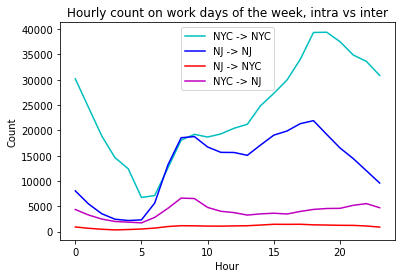

In [71]:
#Check hourly distribution of trips for each direction during work days
h_nj_nj = nj_nj.filter(nj_nj.isWeekend == 0).select(['Hour','Trip_distance']).rdd.groupByKey() \
    .mapValues(lambda x: (sum(list(x))/len(list(x)), len(x))).sortByKey() \
    .flatMap(lambda x: [x[1][1]]).collect()
h_nj_nyc = nj_nyc.filter(nj_nyc.isWeekend == 0).select(['Hour','Trip_distance']).rdd.groupByKey() \
    .mapValues(lambda x: (sum(list(x))/len(list(x)), len(x))).sortByKey() \
    .flatMap(lambda x: [x[1][1]]).collect()
h_nyc_nj = nyc_nj.filter(nyc_nj.isWeekend == 0).select(['Hour','Trip_distance']).rdd.groupByKey() \
    .mapValues(lambda x: (sum(list(x))/len(list(x)), len(x))).sortByKey() \
    .flatMap(lambda x: [x[1][1]]).collect()
h_nyc_nyc = nyc_nyc.filter(nyc_nyc.isWeekend == 0).select(['Hour','Trip_distance']).rdd.groupByKey() \
    .mapValues(lambda x: (sum(list(x))/len(list(x)), len(x))).sortByKey() \
    .flatMap(lambda x: [x[1][1]]).collect()

h_r = range(0,24)

plt.plot(h_r, h_nyc_nyc, color = 'c', label = 'NYC -> NYC')
plt.plot(h_r, h_nj_nj, color = 'b', label = 'NJ -> NJ')
plt.plot(h_r, h_nj_nyc, color = 'r', label = 'NJ -> NYC')
plt.plot(h_r, h_nyc_nj, color = 'm', label = 'NYC -> NJ')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Hourly count on work days of the week, intra vs inter')
plt.legend()
plt.show()

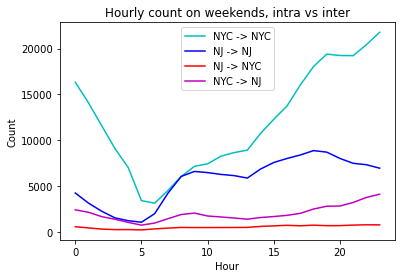

In [72]:
#Check hourly distribution of trips for each direction during weekends
h_nj_nj = nj_nj.filter(nj_nj.isWeekend == 1).select(['Hour','Trip_distance']).rdd.groupByKey() \
    .mapValues(lambda x: (sum(list(x))/len(list(x)), len(x))).sortByKey() \
    .flatMap(lambda x: [x[1][1]]).collect()
h_nj_nyc = nj_nyc.filter(nj_nyc.isWeekend == 1).select(['Hour','Trip_distance']).rdd.groupByKey() \
    .mapValues(lambda x: (sum(list(x))/len(list(x)), len(x))).sortByKey() \
    .flatMap(lambda x: [x[1][1]]).collect()
h_nyc_nj = nyc_nj.filter(nyc_nj.isWeekend == 1).select(['Hour','Trip_distance']).rdd.groupByKey() \
    .mapValues(lambda x: (sum(list(x))/len(list(x)), len(x))).sortByKey() \
    .flatMap(lambda x: [x[1][1]]).collect()
h_nyc_nyc = nyc_nyc.filter(nyc_nyc.isWeekend == 1).select(['Hour','Trip_distance']).rdd.groupByKey() \
    .mapValues(lambda x: (sum(list(x))/len(list(x)), len(x))).sortByKey() \
    .flatMap(lambda x: [x[1][1]]).collect()

h_r = range(0,24)

plt.plot(h_r, h_nyc_nyc, color = 'c', label = 'NYC -> NYC')
plt.plot(h_r, h_nj_nj, color = 'b', label = 'NJ -> NJ')
plt.plot(h_r, h_nj_nyc, color = 'r', label = 'NJ -> NYC')
plt.plot(h_r, h_nyc_nj, color = 'm', label = 'NYC -> NJ')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Hourly count on weekends, intra vs inter')
plt.legend()
plt.show()

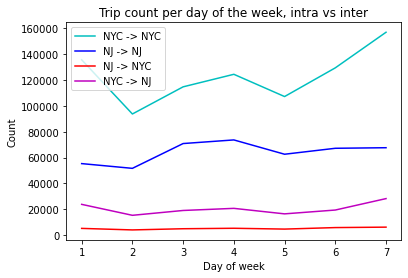

In [73]:
#Check distribution of trips per weekday
w_nj_nj = nj_nj.select(['Weekday','Trip_distance']).rdd.groupByKey() \
    .mapValues(lambda x: (sum(list(x))/len(list(x)), len(x))).sortByKey() \
    .flatMap(lambda x: [x[1][1]]).collect()
w_nj_nyc = nj_nyc.select(['Weekday','Trip_distance']).rdd.groupByKey() \
    .mapValues(lambda x: (sum(list(x))/len(list(x)), len(x))).sortByKey() \
    .flatMap(lambda x: [x[1][1]]).collect()
w_nyc_nj = nyc_nj.select(['Weekday','Trip_distance']).rdd.groupByKey() \
    .mapValues(lambda x: (sum(list(x))/len(list(x)), len(x))).sortByKey() \
    .flatMap(lambda x: [x[1][1]]).collect()
w_nyc_nyc = nyc_nyc.select(['Weekday','Trip_distance']).rdd.groupByKey() \
    .mapValues(lambda x: (sum(list(x))/len(list(x)), len(x))).sortByKey() \
    .flatMap(lambda x: [x[1][1]]).collect()

w_r = range(1, 8)

plt.plot(w_r, w_nyc_nyc, color = 'c', label = 'NYC -> NYC')
plt.plot(w_r, w_nj_nj, color = 'b', label = 'NJ -> NJ')
plt.plot(w_r, w_nj_nyc, color = 'r', label = 'NJ -> NYC')
plt.plot(w_r, w_nyc_nj, color = 'm', label = 'NYC -> NJ')
plt.xlabel('Day of week')
plt.ylabel('Count')
plt.title('Trip count per day of the week, intra vs inter')
plt.legend()
plt.show()

In [74]:
#See distribution of passenger count for each direction
values = ['0','1','2','3','4','5','6','7','8','9'] #possible amount of passengers

pivoted_nj_nj = nj_nj.groupBy('isWeekend').pivot('Passenger_count', values).count()
row_total = sum(F.coalesce(F.col(x), F.lit(0)) for x in values)
adjusted = [F.round(F.col(c) / row_total * 100, 2).alias(c) for c in values]
pivoted_nj_nj = pivoted_nj_nj.select(F.col("isWeekend"), *adjusted)

pivoted_nj_nyc = nj_nyc.groupBy('isWeekend').pivot('Passenger_count', values).count()
row_total = sum(F.coalesce(F.col(x), F.lit(0)) for x in values)
adjusted = [F.round(F.col(c) / row_total * 100, 2).alias(c) for c in values]
pivoted_nj_nyc = pivoted_nj_nyc.select(F.col("isWeekend"), *adjusted)

pivoted_nyc_nj = nyc_nj.groupBy('isWeekend').pivot('Passenger_count', values).count()
row_total = sum(F.coalesce(F.col(x), F.lit(0)) for x in values)
adjusted = [F.round(F.col(c) / row_total * 100, 2).alias(c) for c in values]
pivoted_nyc_nj = pivoted_nyc_nj.select(F.col("isWeekend"), *adjusted)

pivoted_nyc_nyc = nyc_nyc.groupBy('isWeekend').pivot('Passenger_count', values).count()
row_total = sum(F.coalesce(F.col(x), F.lit(0)) for x in values)
adjusted = [F.round(F.col(c) / row_total * 100, 2).alias(c) for c in values]
pivoted_nyc_nyc = pivoted_nyc_nyc.select(F.col("isWeekend"), *adjusted)


In [75]:
#Check distribtuion during workday
njnj = pivoted_nj_nj.filter(pivoted_nj_nj.isWeekend == 0) \
    .select([F.col(c) for c in values]) \
    .withColumn('direction', F.lit('NJ -> NJ'))
njnyc = pivoted_nj_nyc.filter(pivoted_nj_nyc.isWeekend == 0) \
    .select([F.col(c) for c in values]) \
    .withColumn('direction', F.lit('NJ -> NYC'))
nycnj = pivoted_nyc_nj.filter(pivoted_nyc_nj.isWeekend == 0) \
    .select([F.col(c) for c in values]) \
    .withColumn('direction', F.lit('NYC -> NJ'))
nycnyc = pivoted_nyc_nyc.filter(pivoted_nyc_nyc.isWeekend == 0) \
    .select([F.col(c) for c in values]) \
    .withColumn('direction', F.lit('NYC -> NYC'))

workday_dist = njnj.union(njnyc).union(nycnj).union(nycnyc)
workday_dist.show()

#Check distribution during weekend
njnj = pivoted_nj_nj.filter(pivoted_nj_nj.isWeekend == 1) \
    .select([F.col(c) for c in values]) \
    .withColumn('direction', F.lit('NJ -> NJ'))
njnyc = pivoted_nj_nyc.filter(pivoted_nj_nyc.isWeekend == 1) \
    .select([F.col(c) for c in values]) \
    .withColumn('direction', F.lit('NJ -> NYC'))
nycnj = pivoted_nyc_nj.filter(pivoted_nyc_nj.isWeekend == 1) \
    .select([F.col(c) for c in values]) \
    .withColumn('direction', F.lit('NYC -> NJ'))
nycnyc = pivoted_nyc_nyc.filter(pivoted_nyc_nyc.isWeekend == 1) \
    .select([F.col(c) for c in values]) \
    .withColumn('direction', F.lit('NYC -> NYC'))

weekend_dist = njnj.union(njnyc).union(nycnj).union(nycnyc)
weekend_dist.show()

+----+-----+----+----+----+----+----+----+----+----+----------+
|   0|    1|   2|   3|   4|   5|   6|   7|   8|   9| direction|
+----+-----+----+----+----+----+----+----+----+----+----------+
|0.04| 87.8|5.86|1.58|0.45|3.05|1.21| 0.0| 0.0| 0.0|  NJ -> NJ|
|0.09|86.37|6.89|1.78|0.52|3.29|1.06|null|null| 0.0| NJ -> NYC|
|0.01|81.77|8.69|2.95|0.76|3.94|1.88| 0.0|null|null| NYC -> NJ|
|0.03|82.65|8.27|2.43| 0.7|4.37|1.56| 0.0| 0.0| 0.0|NYC -> NYC|
+----+-----+----+----+----+----+----+----+----+----+----------+



+----+-----+----+----+----+----+----+----+----+----+----------+
|   0|    1|   2|   3|   4|   5|   6|   7|   8|   9| direction|
+----+-----+----+----+----+----+----+----+----+----+----------+
|0.05|87.29|6.27|1.68|0.48|3.06|1.16|null| 0.0| 0.0|  NJ -> NJ|
| 0.1|85.83|7.46|1.83|0.61|3.02|1.14|0.01|null|null| NJ -> NYC|
| 0.0|80.54|9.27|3.31|0.96|4.01| 1.9|null|null| 0.0| NYC -> NJ|
|0.02|82.03| 8.7| 2.6|0.79|4.24|1.62|null| 0.0| 0.0|NYC -> NYC|
+----+-----+----+----+----+----+----+----+----+----+----------+



# Task 8.
Could you suggest to Green Taxi how to improve their business? Think about ways they could decrease
cost, get more customers, improve quality of service etc.
In all tasks, try to use the algorithms that you learnt in class, if you didn’t succeed, you can come up
with other tasks yourself using this data set.

In [88]:
#This section will generate html file with primary analysis of the dataset
df_pandas = pd.read_csv("green_tripdata_2015-09.csv")
#analyzing the dataset
advert_report = sv.analyze(df_pandas)
#display the report
advert_report.show_html('NYC_summary.html');

                                             |                         | [  0%]   00:00 -> (? left)

/home/maksat.kengeskanov/.conda/envs/GOS/lib/python3.9/site-packages/sweetviz/utils.py:34: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clamped_series = clamped_series.append(other_series, ignore_index=False)
/home/maksat.kengeskanov/.conda/envs/GOS/lib/python3.9/site-packages/sweetviz/utils.py:34: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clamped_series = clamped_series.append(other_series, ignore_index=False)
/home/maksat.kengeskanov/.conda/envs/GOS/lib/python3.9/site-packages/sweetviz/utils.py:34: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clamped_series = clamped_series.append(other_series, ignore_index=False)
/home/maksat.kengeskanov/.conda/envs/GOS/lib/python3.9/site-packages/sweetviz/series_analyzer.py:16:

Report NYC_summary.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [89]:
#Generate html file with the analysis of cleaned data 
advert_report = sv.analyze(df_cleaned_pandas)
advert_report.show_html('NYC_clean_summary.html');

                                             |                         | [  0%]   00:00 -> (? left)

/home/maksat.kengeskanov/.conda/envs/GOS/lib/python3.9/site-packages/sweetviz/utils.py:34: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clamped_series = clamped_series.append(other_series, ignore_index=False)
/home/maksat.kengeskanov/.conda/envs/GOS/lib/python3.9/site-packages/sweetviz/utils.py:34: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clamped_series = clamped_series.append(other_series, ignore_index=False)
/home/maksat.kengeskanov/.conda/envs/GOS/lib/python3.9/site-packages/sweetviz/utils.py:34: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clamped_series = clamped_series.append(other_series, ignore_index=False)
/home/maksat.kengeskanov/.conda/envs/GOS/lib/python3.9/site-packages/sweetviz/series_analyzer.py:16:

Report NYC_clean_summary.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [90]:
#Add ids to the tables 
centers = centers.withColumn("row_id", monotonically_increasing_id())
cluster_size = cluster_size.withColumn("row_id", monotonically_increasing_id())
result_df = centers.join(cluster_size, ("row_id")).drop("row_id")

In [91]:
result_df_pd = result_df.toPandas()

22/04/26 00:50:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/26 00:50:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/26 00:50:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/26 00:50:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/26 00:50:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/26 00:50:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/26 0

In [92]:
result_df_pd = result_df_pd.sort_values("percentage", ascending=False)
result_df_pd

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,prediction,avg(Trip_distance),avg(Total_amount),size,min(Trip_distance),min(Total_amount),max(Trip_distance),max(Total_amount),percentage
9,-73.945084,40.810187,-73.943835,40.811764,4,1.758197,10.578049,289063,0.0,-250.0,45.17,490.00,19.383446
0,-73.899664,40.751731,-73.899561,40.753556,0,2.615992,13.325704,264346,0.0,-120.0,47.38,300.30,17.726019
1,-73.980787,40.686442,-73.985167,40.684743,7,2.374094,13.583966,214657,0.0,-475.0,47.46,475.00,14.394067
5,-73.960419,40.712647,-73.965620,40.735622,1,3.928724,19.326008,179396,0.0,-75.0,45.40,500.00,12.029601
7,-73.951357,40.693450,-73.936585,40.684702,8,2.876448,15.155924,154991,0.0,-475.0,48.10,485.54,10.393096
3,-73.943839,40.798886,-73.972842,40.763457,9,4.221032,19.935724,151150,0.0,-52.8,47.30,250.38,10.135534
8,-73.837808,40.725791,-73.827996,40.721040,2,2.939137,14.228708,100952,0.0,-400.0,49.00,450.00,6.769450
2,-73.903321,40.843156,-73.893199,40.851252,6,3.129868,14.297222,87341,0.0,-400.0,50.00,581.30,5.856749
6,-73.964397,40.637810,-73.960265,40.626080,3,3.390594,16.442610,31479,0.0,-450.0,45.18,500.00,2.110860
4,-73.941347,40.736075,-73.786315,40.667584,5,14.042534,48.779132,17913,0.0,0.0,49.05,450.00,1.201176


In [93]:
result_df = result_df.withColumn("size_plot", result_df['size']/ 2000)

22/04/26 00:51:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/26 00:51:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/26 00:51:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/26 00:51:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/26 00:51:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/26 00:51:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/26 0

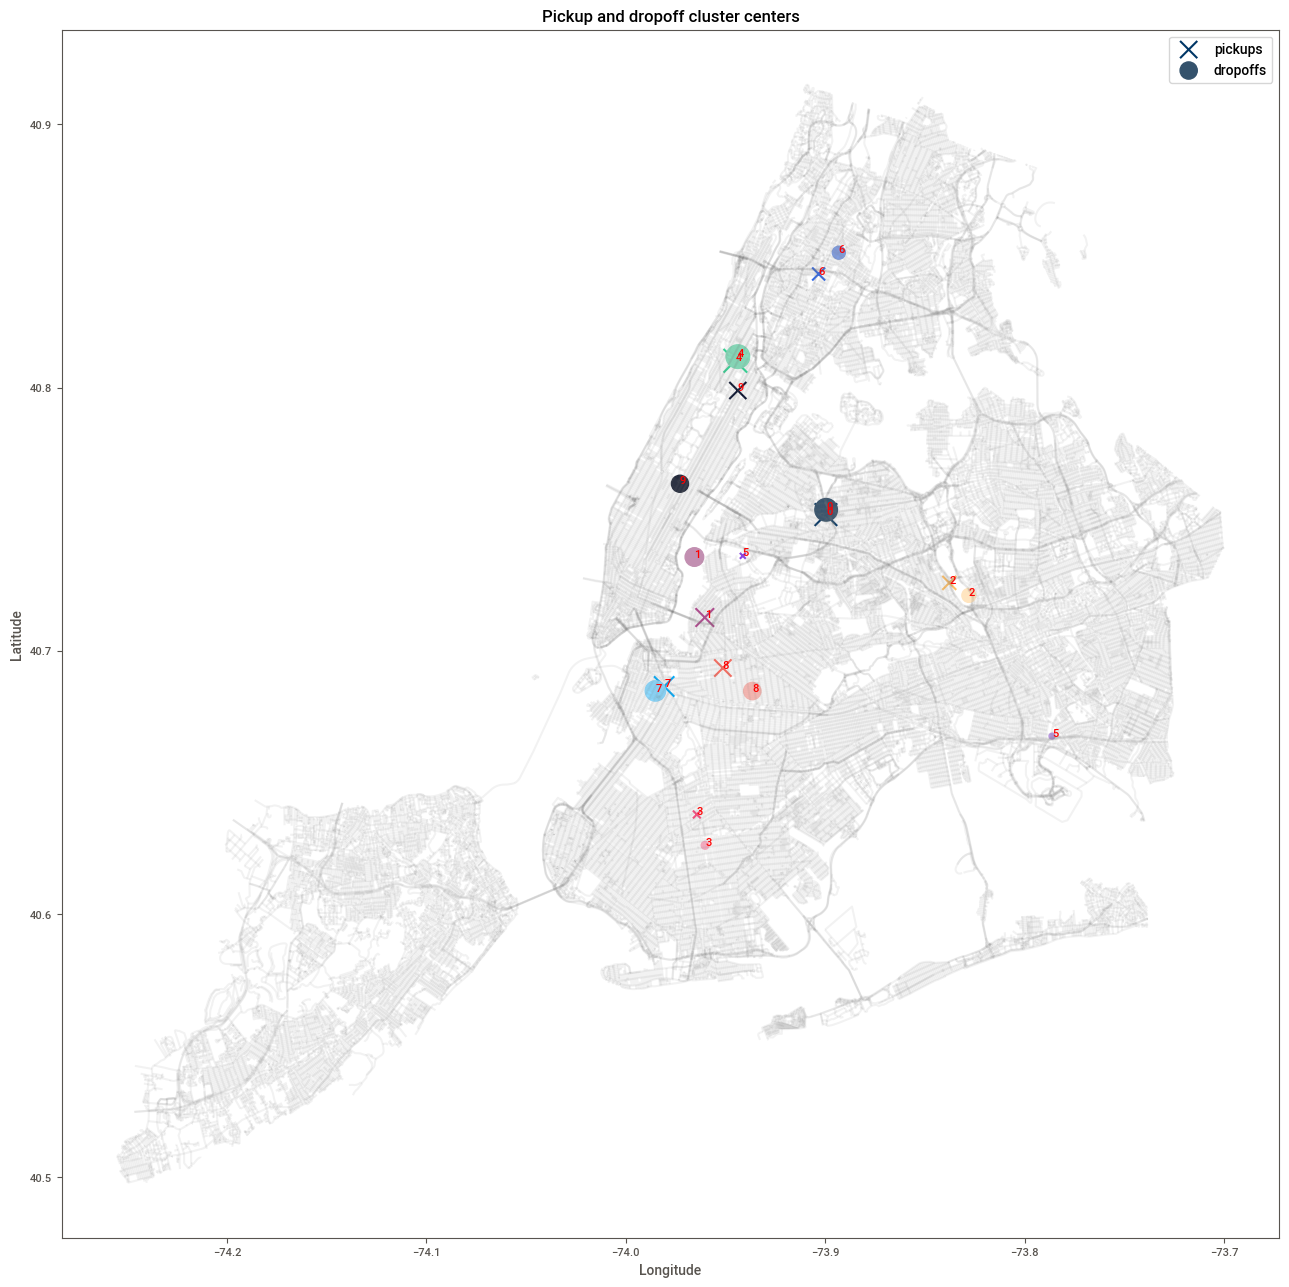

In [94]:
# #More detailed plots of the cluster centers in task 6
# nycmap = gpd.read_file('nyc.shx')
# fig, ax = plt.subplots(figsize = (16, 16))
# crs = {'init': 'epsg:4326'}
# nycmap.plot(ax = ax, color = 'grey', alpha = 0.1)

# #Plot pickup coordinate centroids
# pu_all_long = result_df.select('pickup_longitude').rdd.flatMap(lambda x:x).collect()
# pu_all_lat = result_df.select('pickup_latitude').rdd.flatMap(lambda x:x).collect()
# geometry = gpd.points_from_xy(pu_all_long, pu_all_lat)
# result_df_pd = result_df.toPandas()
# result_df_pd['pickups_color'] = ['#003666', '#00aeff', '#3369e7', '#050f2c', '#8e43e7', '#b84592', '#ff4f81', '#ff6c5f', '#ffc168', '#2dde98']
# geo_pu_all = gpd.GeoDataFrame(result_df_pd, crs = crs, geometry = geometry)

# geo_pu_all.plot(ax = ax, markersize = result_df_pd["size"]/1000, color = result_df_pd['pickups_color'], marker = 'x', label = 'pickups') 

# #Plot dropoff coordinate centroids
# pu_all_long = result_df.select('dropoff_longitude').rdd.flatMap(lambda x:x).collect()
# pu_all_lat = result_df.select('dropoff_latitude').rdd.flatMap(lambda x:x).collect()
# geometry = gpd.points_from_xy(pu_all_long, pu_all_lat)
# result_df_pd['dropoff_color'] = ['#34526c', '#8bdaff', '#819ee2', '#242a3c', '#be9be7', '#c28fb1', '#ffafc6', '#ffbbb5', '#ffe5c0', '#86dfbc']
# geo_pu_all = gpd.GeoDataFrame(result_df_pd, crs = crs, geometry = geometry)
# geo_pu_all.plot(ax = ax, markersize = result_df_pd["size"]/1000, color = result_df_pd['dropoff_color'], marker = 'o', label = 'dropoffs') 
# pick_zip = zip(result_df_pd['pickup_longitude'], result_df_pd['pickup_latitude'], result_df_pd['prediction'])
# drop_zip = zip(result_df_pd['dropoff_longitude'], result_df_pd['dropoff_latitude'], result_df_pd['prediction'])
# for x, y, z in pick_zip:
#     pl.text(x, y, str(z), color="red", fontsize=8)
# for x, y, z in drop_zip:
#     pl.text(x, y, str(z), color="red", fontsize=8)

# ax.legend()
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('Pickup and dropoff cluster centers')
# plt.show()

/home/maksat.kengeskanov/.conda/envs/GOS/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/maksat.kengeskanov/.conda/envs/GOS/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


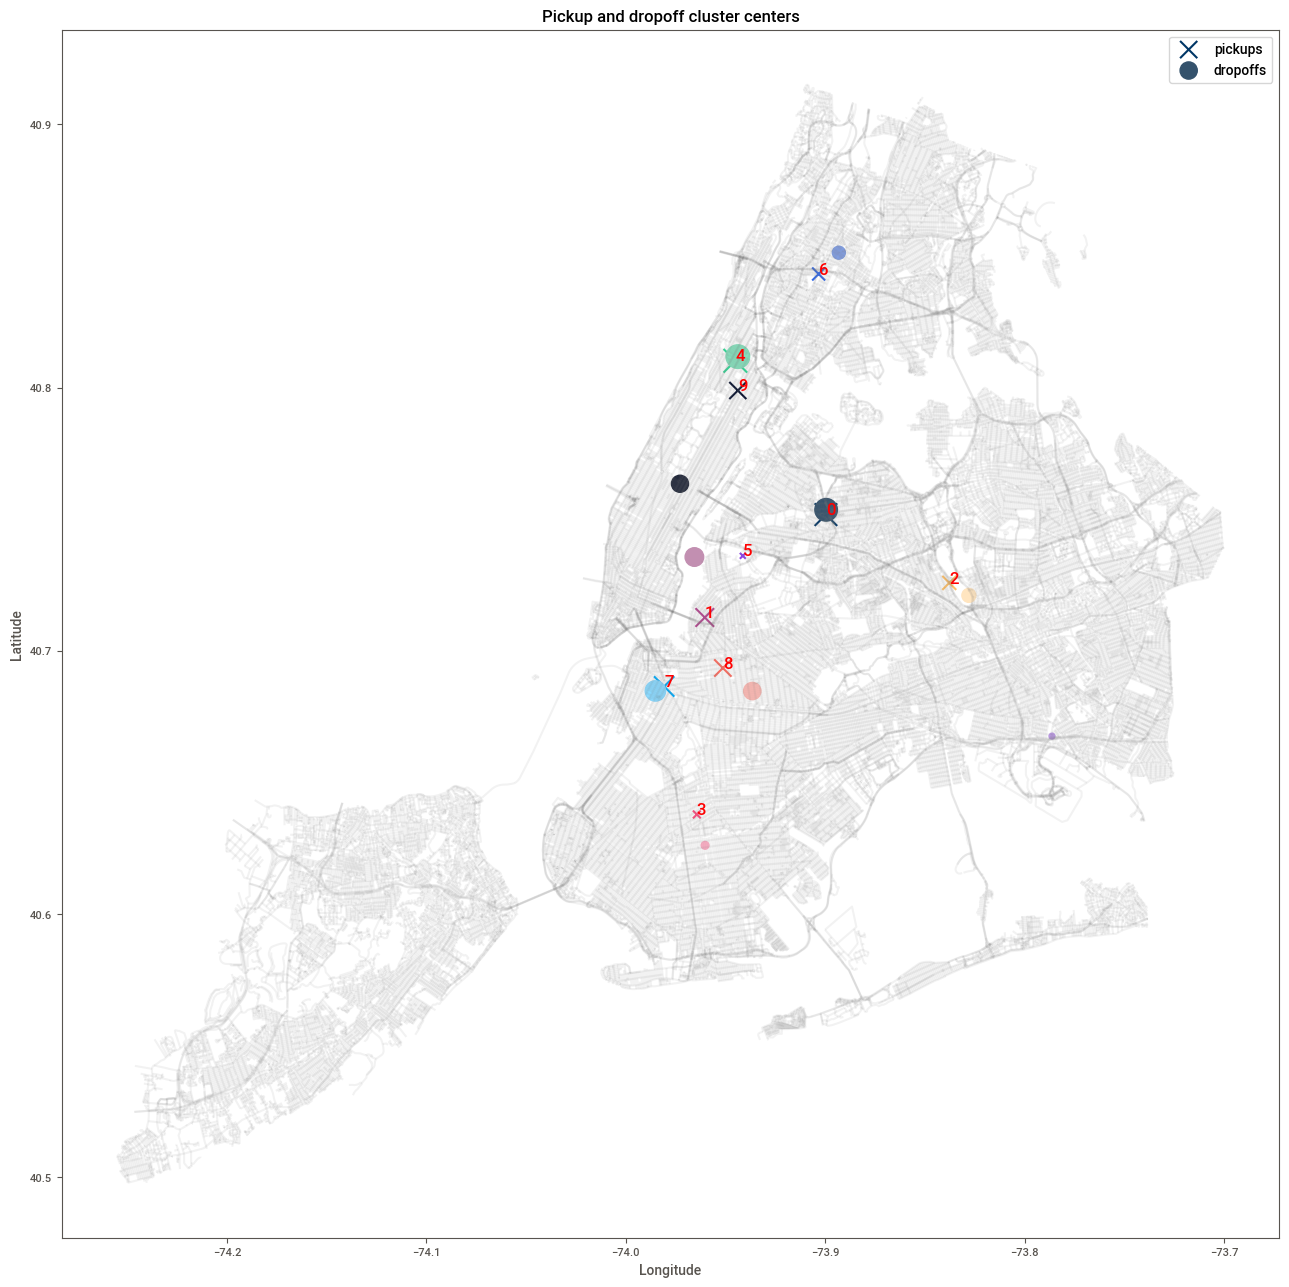

In [95]:
#More detailed plots from the task 6
nycmap = gpd.read_file('nyc.shx')
fig, ax = plt.subplots(figsize = (16, 16))
crs = {'init': 'epsg:4326'}
nycmap.plot(ax = ax, color = 'grey', alpha = 0.1)


pu_all_long = result_df.select('pickup_longitude').rdd.flatMap(lambda x:x).collect()
pu_all_lat = result_df.select('pickup_latitude').rdd.flatMap(lambda x:x).collect()
geometry = gpd.points_from_xy(pu_all_long, pu_all_lat)
result_df_pd = result_df.toPandas()
result_df_pd['pickups_color'] = ['#003666', '#00aeff', '#3369e7', '#050f2c', '#8e43e7', '#b84592', '#ff4f81', '#ff6c5f', '#ffc168', '#2dde98']
geo_pu_all = gpd.GeoDataFrame(result_df_pd, crs = crs, geometry = geometry)

geo_pu_all.plot(ax = ax, markersize = result_df_pd["size"]/1000, color = result_df_pd['pickups_color'], marker = 'x', label = 'pickups') 

pu_all_long = result_df.select('dropoff_longitude').rdd.flatMap(lambda x:x).collect()
pu_all_lat = result_df.select('dropoff_latitude').rdd.flatMap(lambda x:x).collect()
geometry = gpd.points_from_xy(pu_all_long, pu_all_lat)
result_df_pd['dropoff_color'] = ['#34526c', '#8bdaff', '#819ee2', '#242a3c', '#be9be7', '#c28fb1', '#ffafc6', '#ffbbb5', '#ffe5c0', '#86dfbc']
geo_pu_all = gpd.GeoDataFrame(result_df_pd, crs = crs, geometry = geometry)
geo_pu_all.plot(ax = ax, markersize = result_df_pd["size"]/1000, color = result_df_pd['dropoff_color'], marker = 'o', label = 'dropoffs') 
pick_zip = zip(result_df_pd['pickup_longitude'], result_df_pd['pickup_latitude'], result_df_pd['prediction'])
drop_zip = zip(result_df_pd['dropoff_longitude'], result_df_pd['dropoff_latitude'], result_df_pd['prediction'])
for x, y, z in pick_zip:
    pl.text(x, y, str(z), color="red", fontsize=12)


ax.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Pickup and dropoff cluster centers')
plt.show()

In [96]:
display(result_df_pd)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,prediction,avg(Trip_distance),avg(Total_amount),size,min(Trip_distance),min(Total_amount),max(Trip_distance),max(Total_amount),percentage,size_plot,pickups_color,geometry,dropoff_color
0,-73.899664,40.751731,-73.899561,40.753556,0,2.615992,13.325704,264346,0.0,-120.0,47.38,300.30,17.726019,132.1730,#003666,POINT (-73.89956 40.75356),#34526c
1,-73.980787,40.686442,-73.985167,40.684743,7,2.374094,13.583966,214657,0.0,-475.0,47.46,475.00,14.394067,107.3285,#00aeff,POINT (-73.98517 40.68474),#8bdaff
2,-73.903321,40.843156,-73.893199,40.851252,6,3.129868,14.297222,87341,0.0,-400.0,50.00,581.30,5.856749,43.6705,#3369e7,POINT (-73.89320 40.85125),#819ee2
3,-73.943839,40.798886,-73.972842,40.763457,9,4.221032,19.935724,151150,0.0,-52.8,47.30,250.38,10.135534,75.5750,#050f2c,POINT (-73.97284 40.76346),#242a3c
4,-73.941347,40.736075,-73.786315,40.667584,5,14.042534,48.779132,17913,0.0,0.0,49.05,450.00,1.201176,8.9565,#8e43e7,POINT (-73.78632 40.66758),#be9be7
5,-73.960419,40.712647,-73.965620,40.735622,1,3.928724,19.326008,179396,0.0,-75.0,45.40,500.00,12.029601,89.6980,#b84592,POINT (-73.96562 40.73562),#c28fb1
6,-73.964397,40.637810,-73.960265,40.626080,3,3.390594,16.442610,31479,0.0,-450.0,45.18,500.00,2.110860,15.7395,#ff4f81,POINT (-73.96026 40.62608),#ffafc6
7,-73.951357,40.693450,-73.936585,40.684702,8,2.876448,15.155924,154991,0.0,-475.0,48.10,485.54,10.393096,77.4955,#ff6c5f,POINT (-73.93658 40.68470),#ffbbb5
8,-73.837808,40.725791,-73.827996,40.721040,2,2.939137,14.228708,100952,0.0,-400.0,49.00,450.00,6.769450,50.4760,#ffc168,POINT (-73.82800 40.72104),#ffe5c0
9,-73.945084,40.810187,-73.943835,40.811764,4,1.758197,10.578049,289063,0.0,-250.0,45.17,490.00,19.383446,144.5315,#2dde98,POINT (-73.94384 40.81176),#86dfbc


## Cluster the types of trips 

In [107]:
#transform features to cluster trips based on financial stats
features = VectorAssembler(inputCols = ['Total_amount'], outputCol = "features")
client_total_amount = df.filter(df['Total_amount'] != 0.0)
client_total_amount = client_total_amount.dropna(subset = ['Total_amount'])
client_total_amount = features.transform(client_total_amount)
silhouette = []
metric = ClusteringEvaluator()

22/04/26 01:27:38 WARN BlockManager: Asked to remove block broadcast_14156_piece0, which does not exist


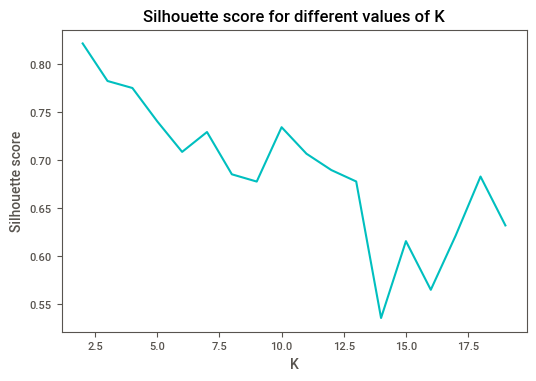

In [108]:
#Finding K
for k in range(2, 20):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(client_total_amount)
    prediction = model.transform(client_total_amount)
    
    score = metric.evaluate(prediction)
    silhouette.append(score)

plt.plot(range(2, 20), silhouette, color = 'c')
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.title('Silhouette score for different values of K')
plt.show()

In [109]:
#We chose K = 6 because has same local max as 10 (and we can explain better the clusters)
kmeans = KMeans().setK(7).setSeed(1)
model3 = kmeans.fit(client_total_amount)
cta_model = model3.transform(client_total_amount)

In [110]:
#Cluster centers
cluster_size = cta_model.groupBy('prediction').agg({'id': 'count'})
cluster_size = cluster_size.withColumn('percentage',F.col('count(id)')/F.sum('count(id)').over(Window.partitionBy())*100)
cluster_size = cluster_size.orderBy('prediction').withColumnRenamed('count(id)', 'size')
centers = model3.clusterCenters()
centers = spark.createDataFrame([i.tolist() for i in centers], ['Total_amount'])
# total_amount_final.show()
# cluster_size.show()

In [111]:
centers = centers.withColumn("row_id", monotonically_increasing_id())
cluster_size = cluster_size.withColumn("row_id", monotonically_increasing_id())
result_df = centers.join(cluster_size, ("row_id")).drop("row_id")

In [112]:
result_df = result_df.sort(result_df.size.desc())

In [113]:
result_df.show()

22/04/26 01:40:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/26 01:40:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------------------+----------+------+--------------------+
|      Total_amount|prediction|  size|          percentage|
+------------------+----------+------+--------------------+
|   8.2366733133686|         0|777967|  52.306948580357435|
|15.789036347208881|         5|427846|   28.76641132890162|
| 26.43551804512449|         1|195325|  13.132761070146056|
|42.562504407210824|         6| 72796|   4.894470625175233|
| 72.56965256225845|         3| 13180|  0.8861630149982082|
| 285.5167027027026|         2|   185|0.012438555218108384|
|          -314.275|         4|    12|8.068252033367601E-4|
+------------------+----------+------+--------------------+



22/04/26 01:40:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/26 01:40:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [114]:
trips_pred_pd = trips_pred.toPandas()

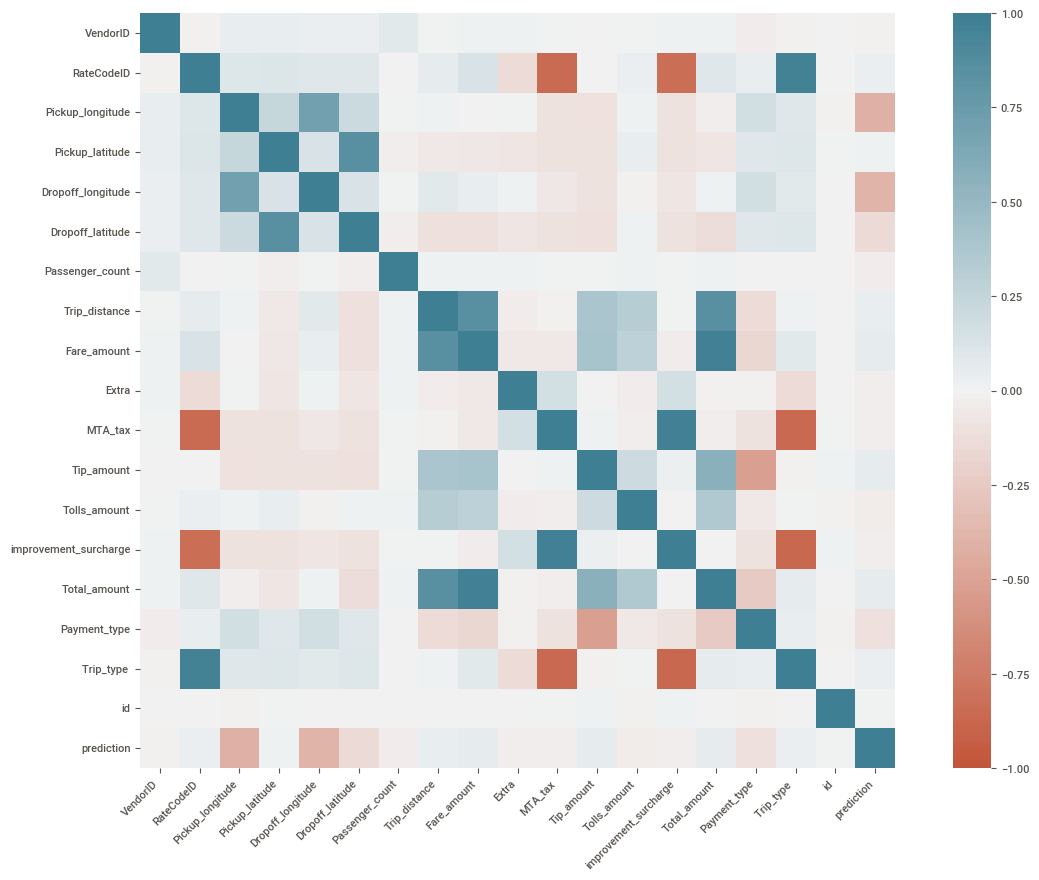

In [115]:
corr = trips_pred_pd.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
    
)
plt.gcf().set_size_inches(15, 10)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);